# Cluster Analysis

In this notebook clusters are analyzed to select those
clusters that meet the validation criteia

## Initial settings

In [1]:
import astropy.units as u
from cdalvaro.catalogues import OpenClust
from cdalvaro.data_base import DB
from cdalvaro.graphics import plot as cplt
from cdalvaro.logging import Logger
from cdalvaro.utils import safe_path, transform
import json
import logging
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

In [2]:
logger = Logger.instance()
logger.setLevel(logging.ERROR)

# cplt.N_SAMPLES = 0
save_figures = cplt.N_SAMPLES == 0

db = DB.instance(host='gaia.cdalvaro.io', port=15432)

figures_save_dir = Path("../../figures")
save_figure_settings = {
    'format': 'png',
    'dpi': 300,
    'save_dir': figures_save_dir
}

## OpenClust catalogue overview

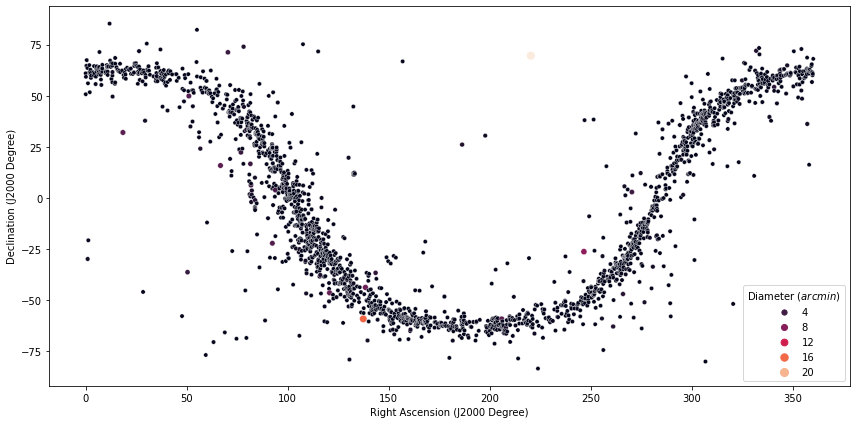

In [3]:
openclust_df = OpenClust.catalogue(as_dataframe=True)
fig, ax, g = cplt.plot_clusters_catalogue_distribution(openclust_df)

if save_figures:
    cplt.save_figure(fig, name='openclust_catalogue', **save_figure_settings)
    cplt.save_figure(fig, name='openclust_catalogue', save_dir=figures_save_dir, format='svg')

## Cluster selection criteria

- diameter > 25.0 arcmin
- abs(parallax) > 0.0
- Number of stars in cluster without null values > 40.000

In [4]:
## Minimun cluster diamater
diam_cut = u.Quantity(25.0, u.arcmin)

## Minimun number of stars in cluster
nstars_cut = 40_000

## Required columns
required_columns = [
    "ra", "dec", "pmra", "pmdec", "parallax", "phot_g_mean_mag", "bp_rp"
]

## Clusters selection

In [5]:
open_clusters = OpenClust.catalogue()
selected_clusters = list()
non_selected_clusters = list()

for cluster in open_clusters.values():
    try:
        cluster_stars = db.get_stars(region=cluster, columns=['parallax'], filter_null_columns=required_columns)
        cluster_stars = cluster_stars[np.abs(cluster_stars['parallax']) > 0.0]

        properties = {
            "name": cluster.name,
            "diam": cluster.diam.to_value(u.arcmin),
            "number_of_stars": len(cluster_stars),
            "number_of_cluster_members": cluster.number_of_cluster_members
        }

        if len(cluster_stars) >= nstars_cut and cluster.diam >= diam_cut:
            selected_clusters.append(properties)
        else:
            non_selected_clusters.append(properties)
    except Exception as error:
        pass

selected_clusters.sort(key=lambda cluster: cluster['number_of_stars'])
non_selected_clusters.sort(key=lambda cluster: cluster['number_of_stars'])

In [6]:
# Save results
file_name = "../../results/cluster_selection_tier1.json"
with open(file_name, "w") as f:
    f.write(json.dumps(selected_clusters))

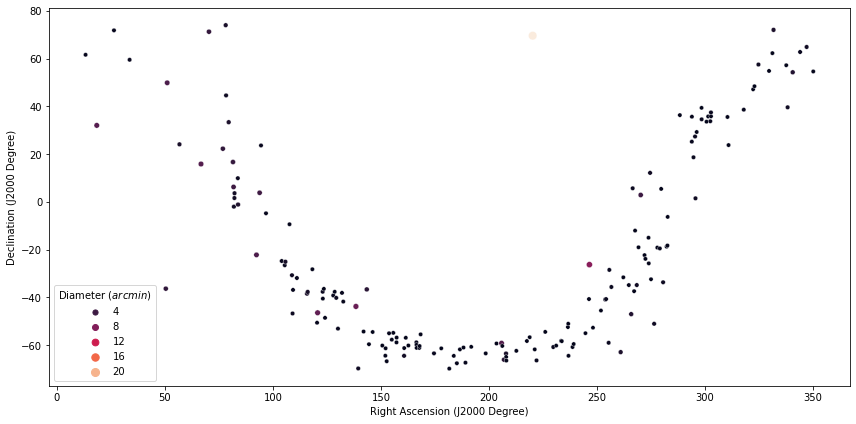

In [7]:
mask = openclust_df.index.isin(list(map(lambda x: x['name'], selected_clusters)))

fig, ax, g = cplt.plot_clusters_catalogue_distribution(openclust_df[mask])
if save_figures:
    cplt.save_figure(fig, name='cluster_selection_tier1', **save_figure_settings)

## Clusters preview

This section studies some of the main parameters for a small cluster selection

In [8]:
clusters_name = {'Melotte 22', 'NGC 2682', 'NGC 6494'}
clusters = OpenClust.get_clusters(names=clusters_name)

### Melotte 22

In [9]:
melotte22 = clusters["Melotte 22"]
df_melotte22 = db.get_stars(region=melotte22)
df_melotte22['cluster_g'] = False

save_dir = figures_save_dir / safe_path(melotte22.name)
save_dir.mkdir(exist_ok=True)
save_figure_settings['save_dir'] = save_dir

pos_lims = { }
pm_lims = { 'xlim':  (-30, 50), 'ylim': (-70, 40) }
parallax_lims = { 'xlim': (-4, 10) }
hr_lims = { 'xlim': (-1, 4), 'ylim': (3, 21) }

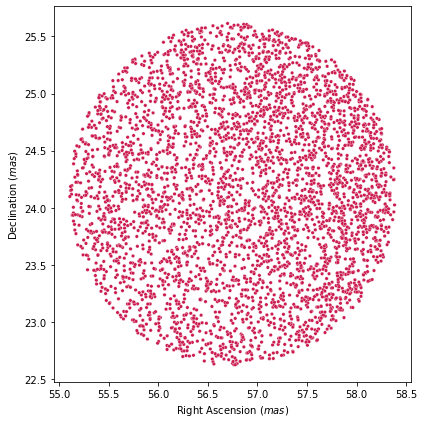

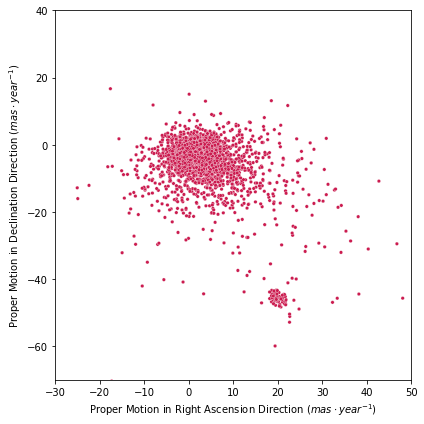

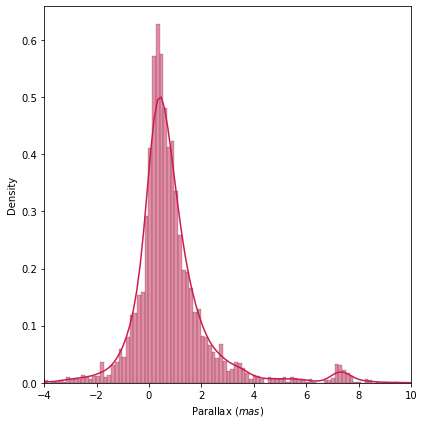

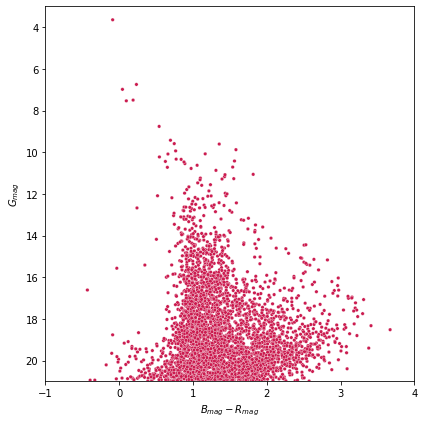

In [10]:
# Position
fig, ax, g = cplt.plot_cluster_position(df_melotte22, **pos_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_pos_{melotte22.name}", **save_figure_settings)

# Proper Motion
fig, ax, g = cplt.plot_cluster_proper_motion(df_melotte22, **pm_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_pm_{melotte22.name}", **save_figure_settings)

# Parallax
fig, ax, g = cplt.plot_cluster_parallax_histogram(df_melotte22, **parallax_lims, stat='density', legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_parallax_{melotte22.name}", **save_figure_settings)

# Isochrone
fig, ax, g = cplt.plot_cluster_hr_diagram_curve(df_melotte22, **hr_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_hr_diagram_{melotte22.name}", **save_figure_settings)

In [11]:
melotte22_csv = pd.read_csv('data/MELOTTE22.csv')
df_melotte22['cluster_g'] = df_melotte22.index.get_level_values('source_id').isin(melotte22_csv.source_id)
df_melotte22['cluster_g'] = df_melotte22['cluster_g'].replace({True: melotte22.name, False: ""})
df_melotte22.sort_values(by='cluster_g', inplace=True)

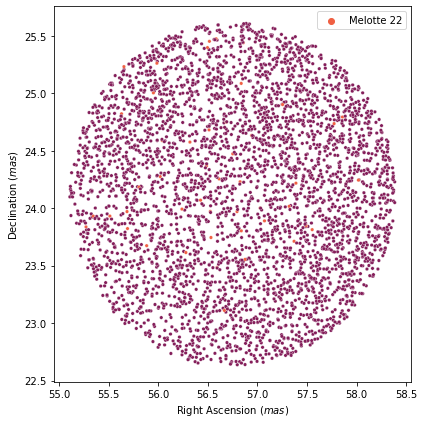

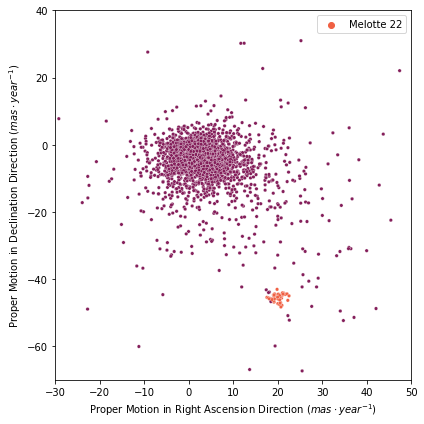

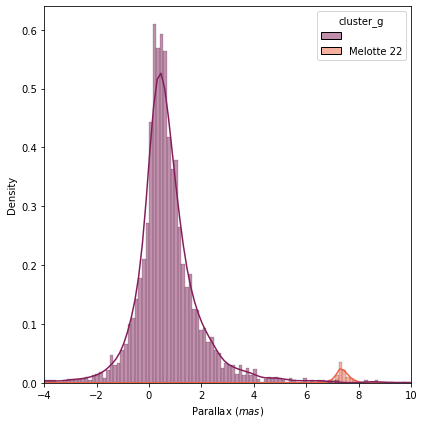

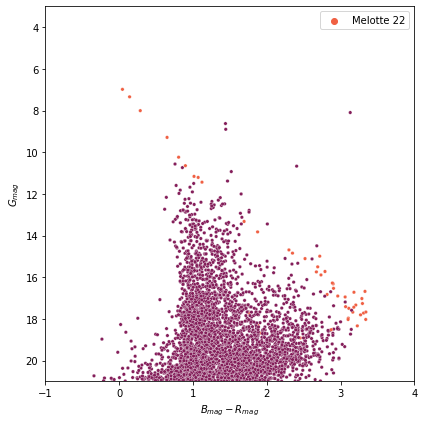

In [12]:
# Position
fig, ax, g = cplt.plot_cluster_position(df_melotte22, **pos_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"pos_{melotte22.name}", **save_figure_settings)

# Proper Motion
fig, ax, g = cplt.plot_cluster_proper_motion(df_melotte22, **pm_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"pm_{melotte22.name}", **save_figure_settings)

# Parallax
fig, ax, g = cplt.plot_cluster_parallax_histogram(df_melotte22, **parallax_lims, stat='density', legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"parallax_{melotte22.name}", **save_figure_settings)

# Isochrone
fig, ax, g = cplt.plot_cluster_hr_diagram_curve(df_melotte22, **hr_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"hr_diagram_{melotte22.name}", **save_figure_settings)

## NGC 2682

In [13]:
ngc2682 = clusters["NGC 2682"]
df_ngc2682 = db.get_stars(region=ngc2682)
df_ngc2682['cluster_g'] = False

save_dir = figures_save_dir / safe_path(ngc2682.name)
save_dir.mkdir(exist_ok=True)
save_figure_settings['save_dir'] = save_dir

pm_lims = { 'xlim': (-20, 10), 'ylim': (-15, 10) }
parallax_lims = { 'xlim': (-1, 3) }
hr_lims = { 'xlim': (0, 3), 'ylim': (8, 21) }

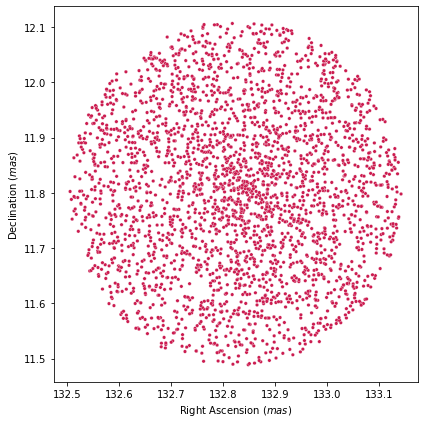

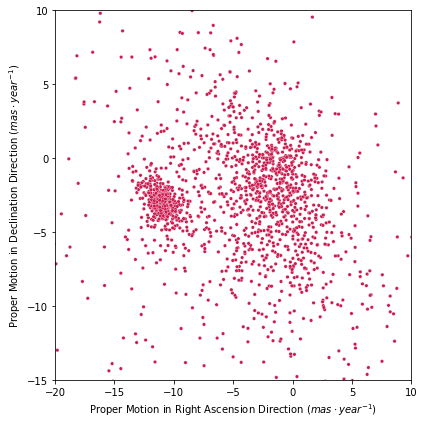

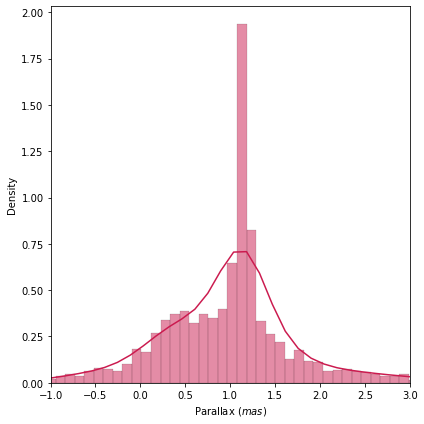

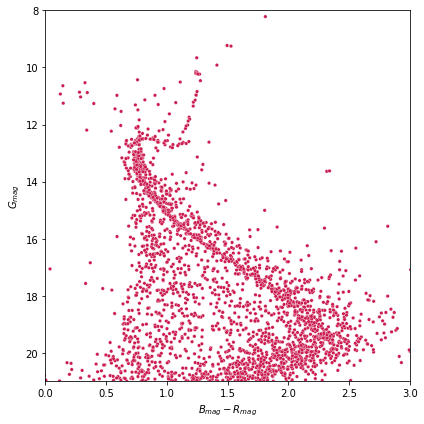

In [14]:
# Position
fig, ax, g = cplt.plot_cluster_position(df_ngc2682, **pos_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_pos_{ngc2682.name}", **save_figure_settings)

# Proper Motion
fig, ax, g = cplt.plot_cluster_proper_motion(df_ngc2682, **pm_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_pm_{ngc2682.name}", **save_figure_settings)

# Parallax
fig, ax, g = cplt.plot_cluster_parallax_histogram(df_ngc2682, **parallax_lims, stat='density', legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_parallax_{ngc2682.name}", **save_figure_settings)

# Isochrone
fig, ax, g = cplt.plot_cluster_hr_diagram_curve(df_ngc2682, **hr_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_hr_diagram_{ngc2682.name}", **save_figure_settings)

In [15]:
ngc2682_csv = pd.read_csv('data/NGC2682.csv')
df_ngc2682['cluster_g'] = df_ngc2682.index.get_level_values('source_id').isin(ngc2682_csv.source_id)
df_ngc2682['cluster_g'] = df_ngc2682['cluster_g'].replace({True: ngc2682.name, False: ""})
df_ngc2682.sort_values(by='cluster_g', inplace=True)

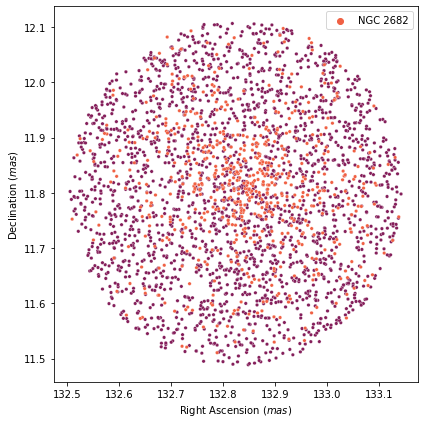

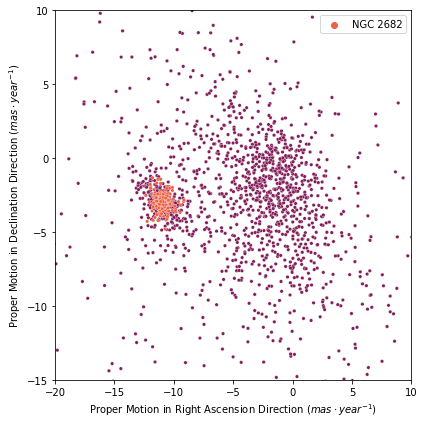

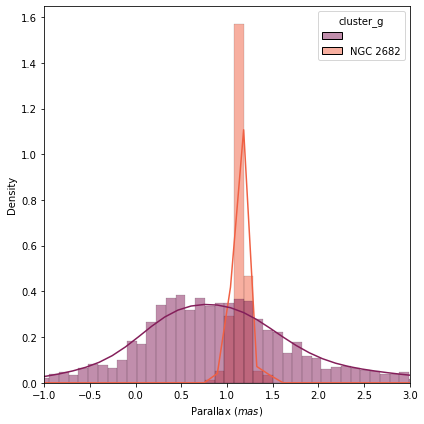

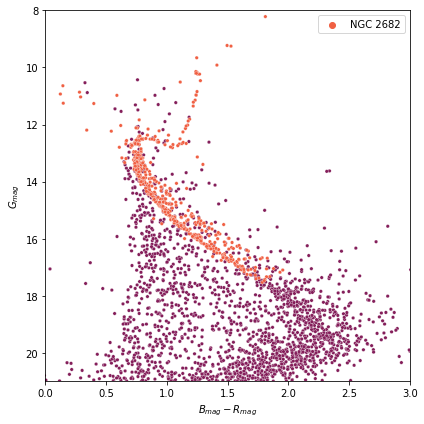

In [16]:
# Position
fig, ax, g = cplt.plot_cluster_position(df_ngc2682, **pos_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"pos_{ngc2682.name}", **save_figure_settings)

# Proper Motion
fig, ax, g = cplt.plot_cluster_proper_motion(df_ngc2682, **pm_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"pm_{ngc2682.name}", **save_figure_settings)

# Parallax
fig, ax, g = cplt.plot_cluster_parallax_histogram(df_ngc2682, **parallax_lims, stat='density', legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"parallax_{ngc2682.name}", **save_figure_settings)

# Isochrone
fig, ax, g = cplt.plot_cluster_hr_diagram_curve(df_ngc2682, **hr_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"hr_diagram_{ngc2682.name}", **save_figure_settings)

## NGC 6494

In [17]:
ngc6494 = clusters["NGC 6494"]
df_ngc6494 = db.get_stars(region=ngc6494)
df_ngc6494['cluster_g'] = False

save_dir = figures_save_dir / safe_path(ngc6494.name)
save_dir.mkdir(exist_ok=True)
save_figure_settings['save_dir'] = save_dir

pm_lims = { 'xlim': (-5, 3), 'ylim': (-5, 2) }
parallax_lims = {
    'xlim': (-2, 3),
    'n_samples': 16_000 if cplt.N_SAMPLES == 0 else None
}
hr_lims = { 'xlim': (0, 3), 'ylim': (8, 21) }

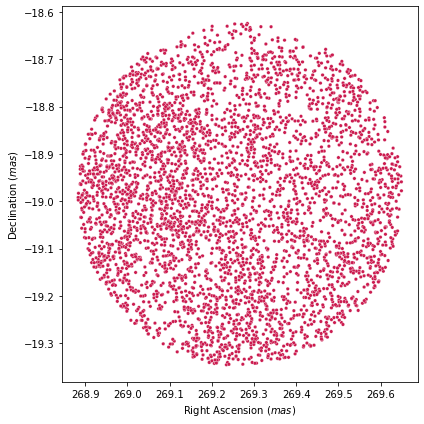

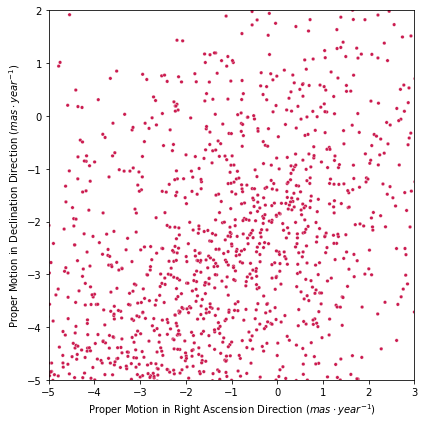

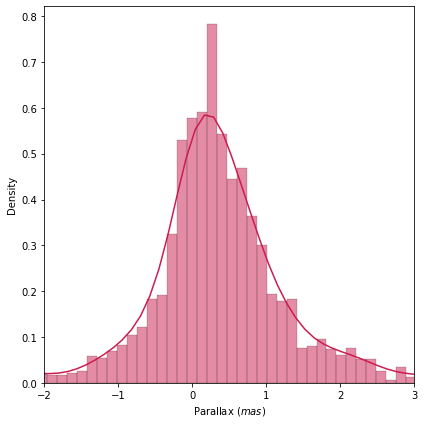

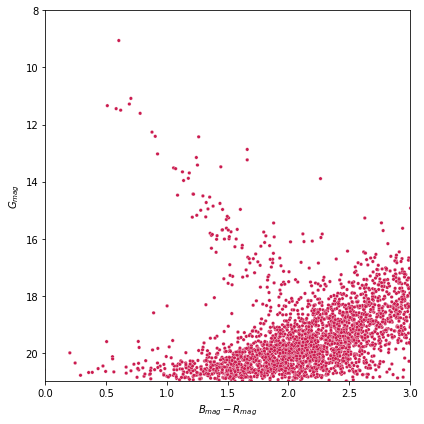

In [18]:
# Position
fig, ax, g = cplt.plot_cluster_position(df_ngc6494, **pos_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_pos_{ngc6494.name}", **save_figure_settings)

# Proper Motion
fig, ax, g = cplt.plot_cluster_proper_motion(df_ngc6494, **pm_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_pm_{ngc6494.name}", **save_figure_settings)

# Parallax
fig, ax, g = cplt.plot_cluster_parallax_histogram(df_ngc6494, **parallax_lims, stat='density', legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_parallax_{ngc6494.name}", **save_figure_settings)

# Isochrone
fig, ax, g = cplt.plot_cluster_hr_diagram_curve(df_ngc6494, **hr_lims, legend=False)
if save_figures:
    cplt.save_figure(fig, name=f"raw_hr_diagram_{ngc6494.name}", **save_figure_settings)

In [19]:
ngc6494_csv = pd.read_csv('data/NGC6494.csv')
df_ngc6494['cluster_g'] = df_ngc6494.index.get_level_values('source_id').isin(ngc6494_csv.source_id)
df_ngc6494['cluster_g'] = df_ngc6494['cluster_g'].replace({True: ngc6494.name, False: ""})
df_ngc6494.sort_values(by='cluster_g', inplace=True)

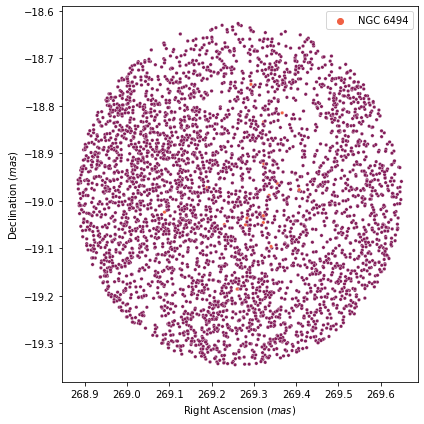

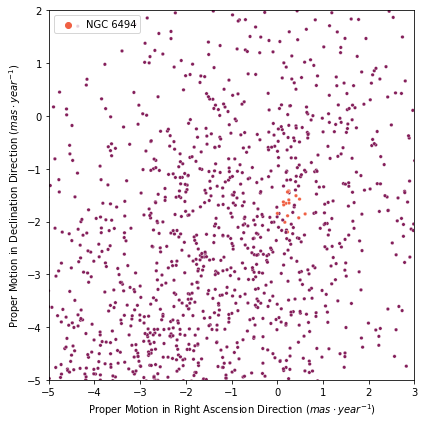

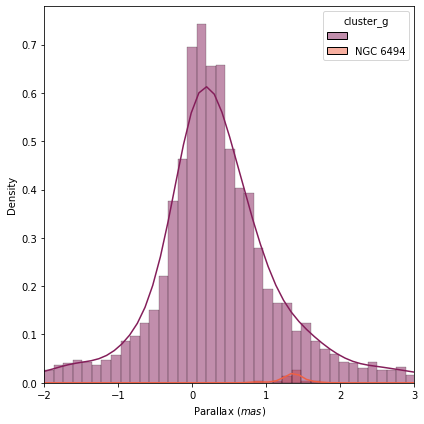

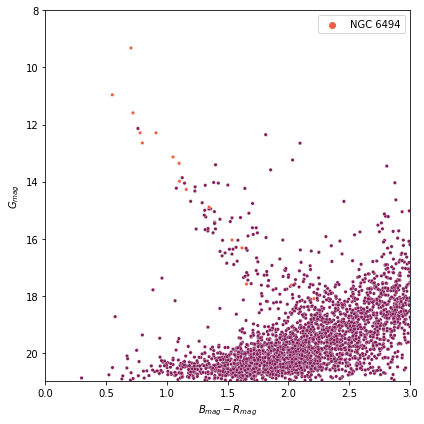

In [20]:
# Position
fig, ax, g = cplt.plot_cluster_position(df_ngc6494, **pos_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"pos_{ngc6494.name}", **save_figure_settings)

# Proper Motion
fig, ax, g = cplt.plot_cluster_proper_motion(df_ngc6494, **pm_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"pm_{ngc6494.name}", **save_figure_settings)

# Parallax
fig, ax, g = cplt.plot_cluster_parallax_histogram(df_ngc6494, **parallax_lims, stat='density', legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"parallax_{ngc6494.name}", **save_figure_settings)

# Isochrone
fig, ax, g = cplt.plot_cluster_hr_diagram_curve(df_ngc6494, **hr_lims, legend=True)
if save_figures:
    cplt.save_figure(fig, name=f"hr_diagram_{ngc6494.name}", **save_figure_settings)

# Downloaded Data Histograms

In [21]:
save_figure_settings['save_dir'] = figures_save_dir

In [22]:
data = list()
number_of_clusters = dict()

number_of_stars_key = 'number_of_stars'
number_of_cluster_members_key = 'number_of_cluster_members'
number_of_clusters_key = 'number_of_clusters'

for entry in selected_clusters + non_selected_clusters:
    diam = entry['diam']
    if diam not in number_of_clusters:
        number_of_clusters[diam] = 0
    number_of_clusters[diam] += 1

    for key in [number_of_stars_key, number_of_cluster_members_key]:
        data.append({
            'diam': diam,
            'value': entry[key] if entry[key] is not None else 0,
            'desc': key
        })

for diam, n_clusters in number_of_clusters.items():
    data.append({
        'diam': diam,
        'value': n_clusters,
        'desc': number_of_clusters_key
    })

data = pd.DataFrame(data)

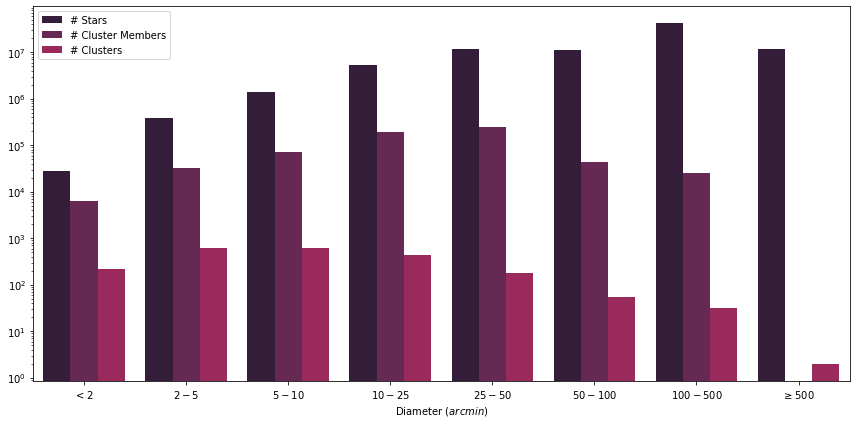

In [23]:
legend_labels = {
    number_of_stars_key: '# Stars',
    number_of_cluster_members_key: '# Cluster Members',
    number_of_clusters_key: '# Clusters'
}

_data = transform.binarize(data, bins=[2, 5, 10, 25, 50, 100, 500], by='diam')
fig, ax, g = cplt.plot_downloaded_data_histogram(_data, legend_labels=legend_labels)
if save_figures:
    cplt.save_figure(fig, name='downloaded_data', **save_figure_settings)

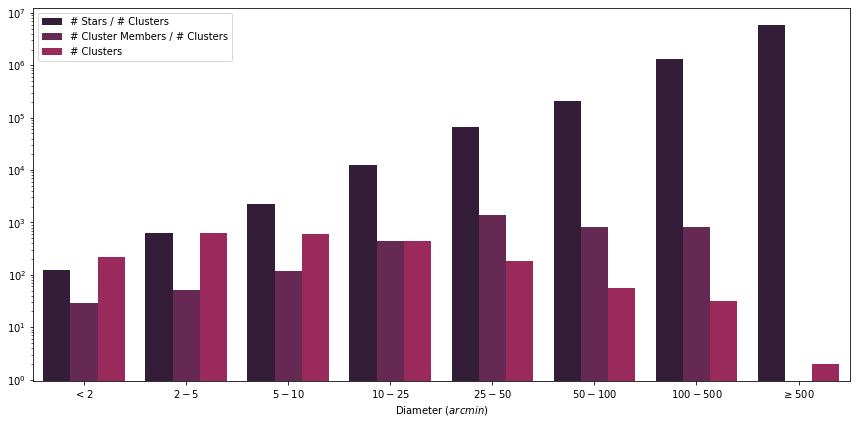

In [24]:
legend_labels = {
    number_of_stars_key: '# Stars / # Clusters',
    number_of_cluster_members_key: '# Cluster Members / # Clusters',
    number_of_clusters_key: '# Clusters'
}

_data = transform.binarize(data, bins=[2, 5, 10, 25, 50, 100, 500], by='diam', norm_by=number_of_clusters_key)
fig, ax, g = cplt.plot_downloaded_data_histogram(_data, legend_labels=legend_labels)
if save_figures:
    cplt.save_figure(fig, name='downloaded_data_norm', **save_figure_settings)